## Chapter 10 Linear multiclass classification

# 10.3  Feature scaling via standard normalization

We have now seen multiple times how *feature scaling* via the *standard normalization* scheme - that is subtracting the mean and dividing off the standard deviation of each input feature - substantially improves our ability to properly tune linear regression and two-class classification cost functions when employing gradient descent and coordinate descent methods (see Sections 8.4 and 9.4).  Unsurprisingly standard normalization provides the same benefits in the case of multiclass classification - whether we employ the One-versus-all framework or the multiclass perceptron / softmax cost - which we explore here.

In [1]:
# This code cell will not be shown in the HTML version of this notebook
# import custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import superlearn_library as superlearn
from mlrefined_libraries import math_optimization_library as optlib
datapath = '../../mlrefined_datasets/superlearn_datasets/'

# demos for this notebook
classif_plotter = superlearn.multi_lin_classification_demo
optimizers = optlib.optimizers
classification_plotter = superlearn.classification_static_plotter.Visualizer();
feature_scaling_tools = superlearn.feature_scaling_tools
static_plotter = superlearn.multiclass_static_plotter.Visualizer()
ova_static_plotter = superlearn.ova_multiclass_static_plotter.Visualizer()
cost_lib = superlearn.cost_functions
normalizers = superlearn.normalizers 

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# import timer
from datetime import datetime 

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

# 10.3.1  One-versus-All classification

As we saw in Section 9.1, One-versus-All (OvA) multiclass classification applied to a dataset with $C$ classes consists of applying $C$ two-class classifiers to the dataset - each assigned to learn a linear separator between a single class and all the other data - and combining the results.  Because we have already seen the benefit of using *standard normalization* in the context of two-class classification (in Section 9.4), clearly employing the same normalization scheme in the context of OvA will provide the same benefits.  Here we illustrate this fact using a simple single-input multiclass dataset, loaded in and shown below.

<IPython.core.display.Javascript object>


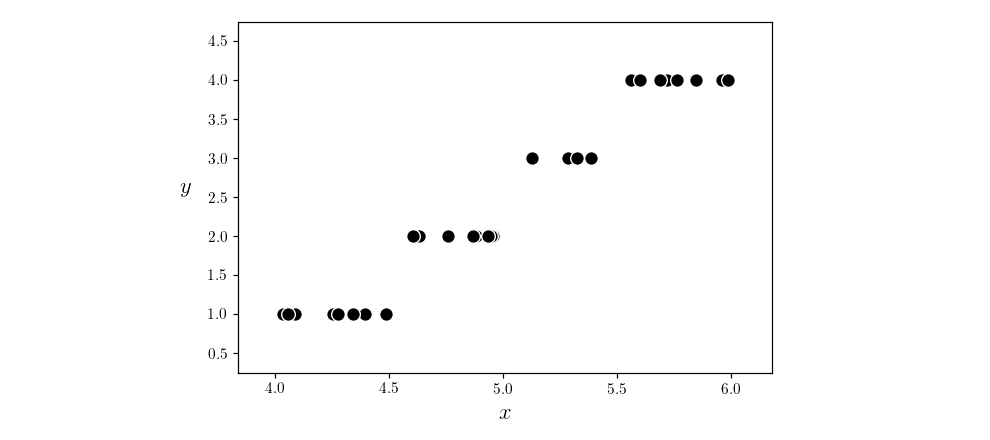

In [2]:
# load in a toy dataset to illustrate the benefits of standard normalization 
data = np.loadtxt(datapath + 'singleinput_multiclass_dataset.csv',delimiter = ',')

# get input/output pairs
x = data[:,:-1:].T 
y = data[:,-1:] 

# multiclass single-input plotter
demo = classif_plotter.Visualizer(data)
demo.plot_data()

Below we train an OvA multiclass classifier to represent / separate the $C = 4$ classes of this dataset.  For each of the $C$ two-class subproblems we use the `softmax` cost function, $\alpha = 10^{-1}$ (the largest fixed steplength of the form $10^{-\gamma}$ with $\gamma$ an integer we could find that produced consistent convergence for this example), and $100$ iterations.  Each subproblem is initialized at the point $\mathbf{w} = \begin{bmatrix} 1 \\ 4 \end{bmatrix}$.

In [4]:
# load in OvA framework
ova = superlearn.one_versus_all

# run OvA on dataset
w = np.array([[1],[4]]); alpha_choice = 10**(-1); max_its = 100;
weight_history_1, count_history_1 = ova.train(x,y,max_its = max_its,alpha_choice = alpha_choice,w = w)

Below we plot each gradient descent run on its corresponding cost function contour, labeling the axes of each contour plot with its respective weights.  Here we can see how the contours of every subplot are highly elliptical, making it extremely difficult for gradient descent to make progress towards a good solution.

<IPython.core.display.Javascript object>


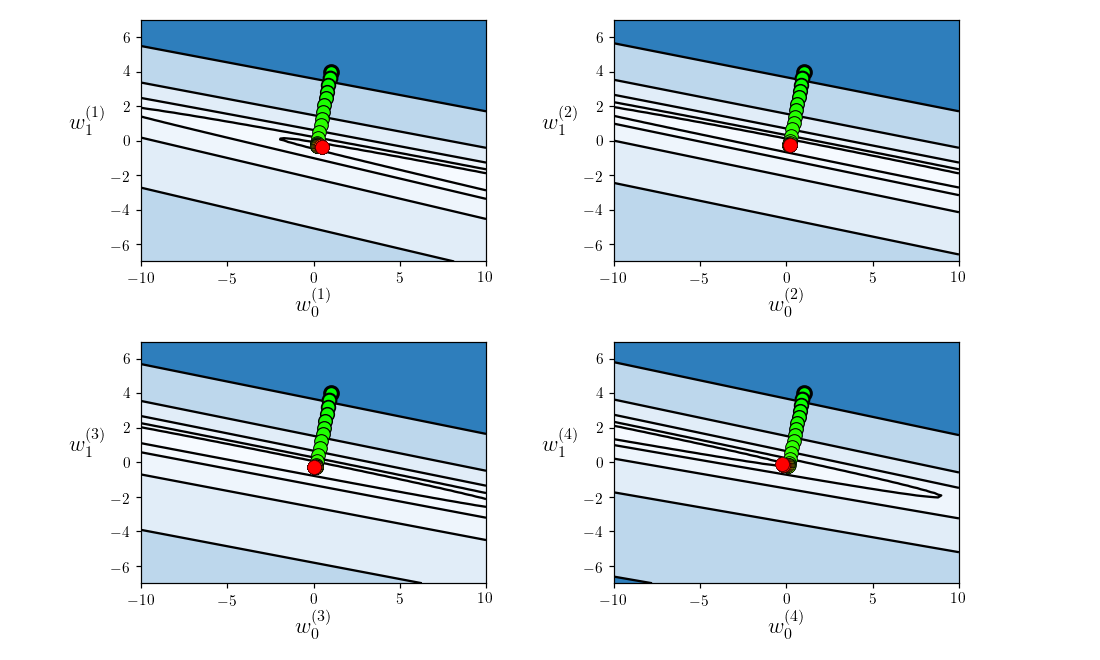

In [5]:
# show run of each sub-problem on respective cost function contour
ova_static_plotter.two_input_contour_plot(weight_history_1,x,y,xmin = -10,xmax = 10,ymin = -7,ymax = 7,num_contours = 5)

Plotting the resulting fit to the data - which we do below - we can see just how poorly we have been able to learn a reasonable representation of this dataset due to the highly skewed contours of its cost functions.  Here notice that the fit shown is produced by evaluating the *fusion rule* described in the previous sections of this Chapter over a fine range of inputs across the input space of the dataset.

<IPython.core.display.Javascript object>


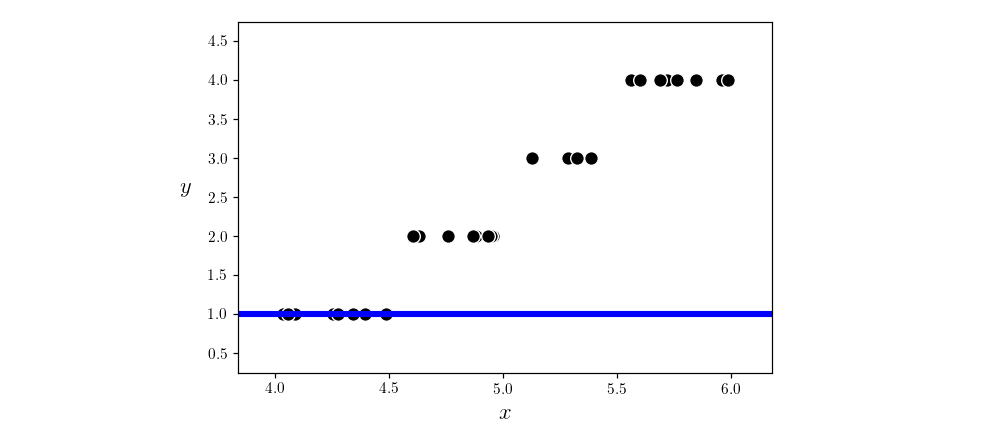

In [7]:
# plot the best learned representation from our run above
ind = np.argmin(count_history_1)
best_weights = weight_history_1[ind]
demo.plot_fit(best_weights)

Lets now compare this to a run of the same general format, but having employed standard normalization first.  That is - since this is a single input dataset - we replace each input by subtracting off the mean of the entire set of inputs and dividing off its standard deviation as

\begin{equation}
x_p \longleftarrow \frac{x_p - \mu}{\sigma}
\end{equation}

where the sample mean of the inputs $\mu$ is defined as 

\begin{equation}
\mu = \frac{1}{P}\sum_{p=1}^{P}x_p \\
\end{equation}

and the sample standard deviation of the inputs $\sigma$ is defined as 

\begin{array}
\
\sigma = \sqrt{\frac{1}{P}\sum_{p=1}^{P}\left(x_p - \mu \right)^2}.
\end{array}

We produced nice `Python` functionality for performing this *standard normalization* in Section 8.4, and we load this in from a backend file called `normalizers` and apply it to our current dataset.  Afterwards we re-run OvA training with for just $10$ steps of gradient descent initialized at the same initial point as above, and use a fixed steplength of $\alpha = 10$ in each instance (again, the largest steplength value we could use of this form that caused convergence).  Notice - as is always the case after normalizing the input of a dataset - that here we can use far fewer steps and a much larger steplength value.

As we can see analyzing the contour plots below, unsurprisingly performing standard normalization greatly improves the contours of each sub-problem cost function making them much easier to minimize.

In [8]:
# create normalizer/inverse normalizer
normalizer,inverse_normalizer = normalizers.standard_normalizer(x)

# normalize input
x_normalized = normalizer(x)

# run one-versus-all 
weight_history_2, count_history_2 = ova.train(x_normalized,y,max_its = 10,alpha_choice = 10,w = w)

<IPython.core.display.Javascript object>


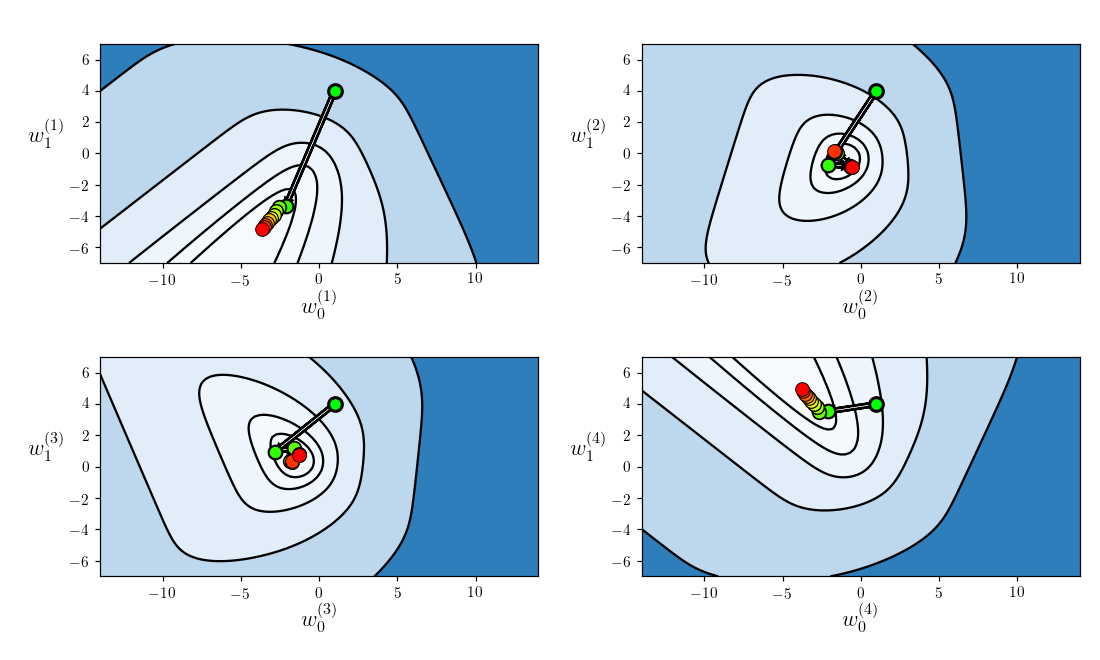

In [9]:
# show run on contour plot
ova_static_plotter.two_input_contour_plot(weight_history_2,x_normalized,y,xmin = -14,xmax = 14,ymin = -7,ymax = 7,num_contours = 5)

Examining the corresponding fit - plotted below - we can gain significantly better performance.  Note - as is always the case - in order to evaluate new test points (e.g., to produce the plotted fit shown below) we must normalize them precisely as we did the training data.

<IPython.core.display.Javascript object>


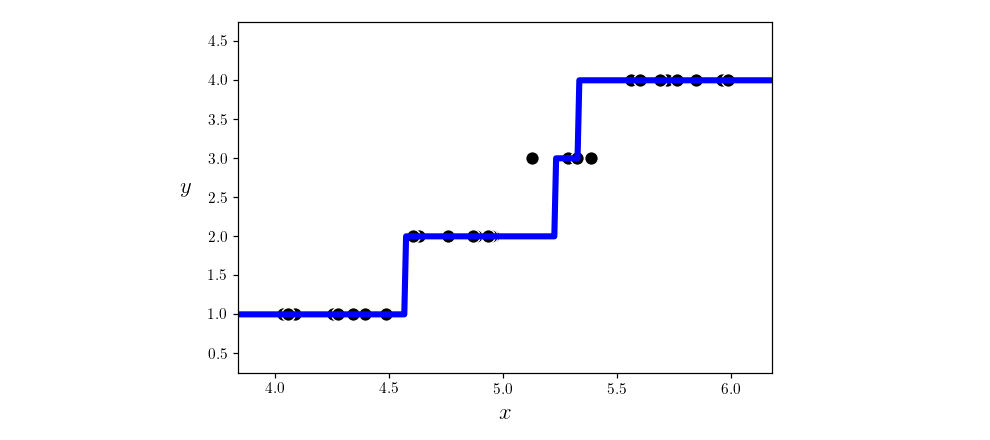

In [10]:
# plot the best learned representation from our run above
ind = np.argmin(count_history_2)
best_weights = weight_history_2[ind]
demo.plot_fit(best_weights,transformer = normalizer)

# 10.3.2  Simultaneous multiclass frameworks

Standard normalization also substantially improves training for simultaneous multiclass frameworks - the multiclass perceptron and softmax functions.  As a simple example illustrating this fact, we first examine how well multiclass perceptron fits to the same toy dataset used in the previous Subsection - before and after normalizing its input.

<IPython.core.display.Javascript object>


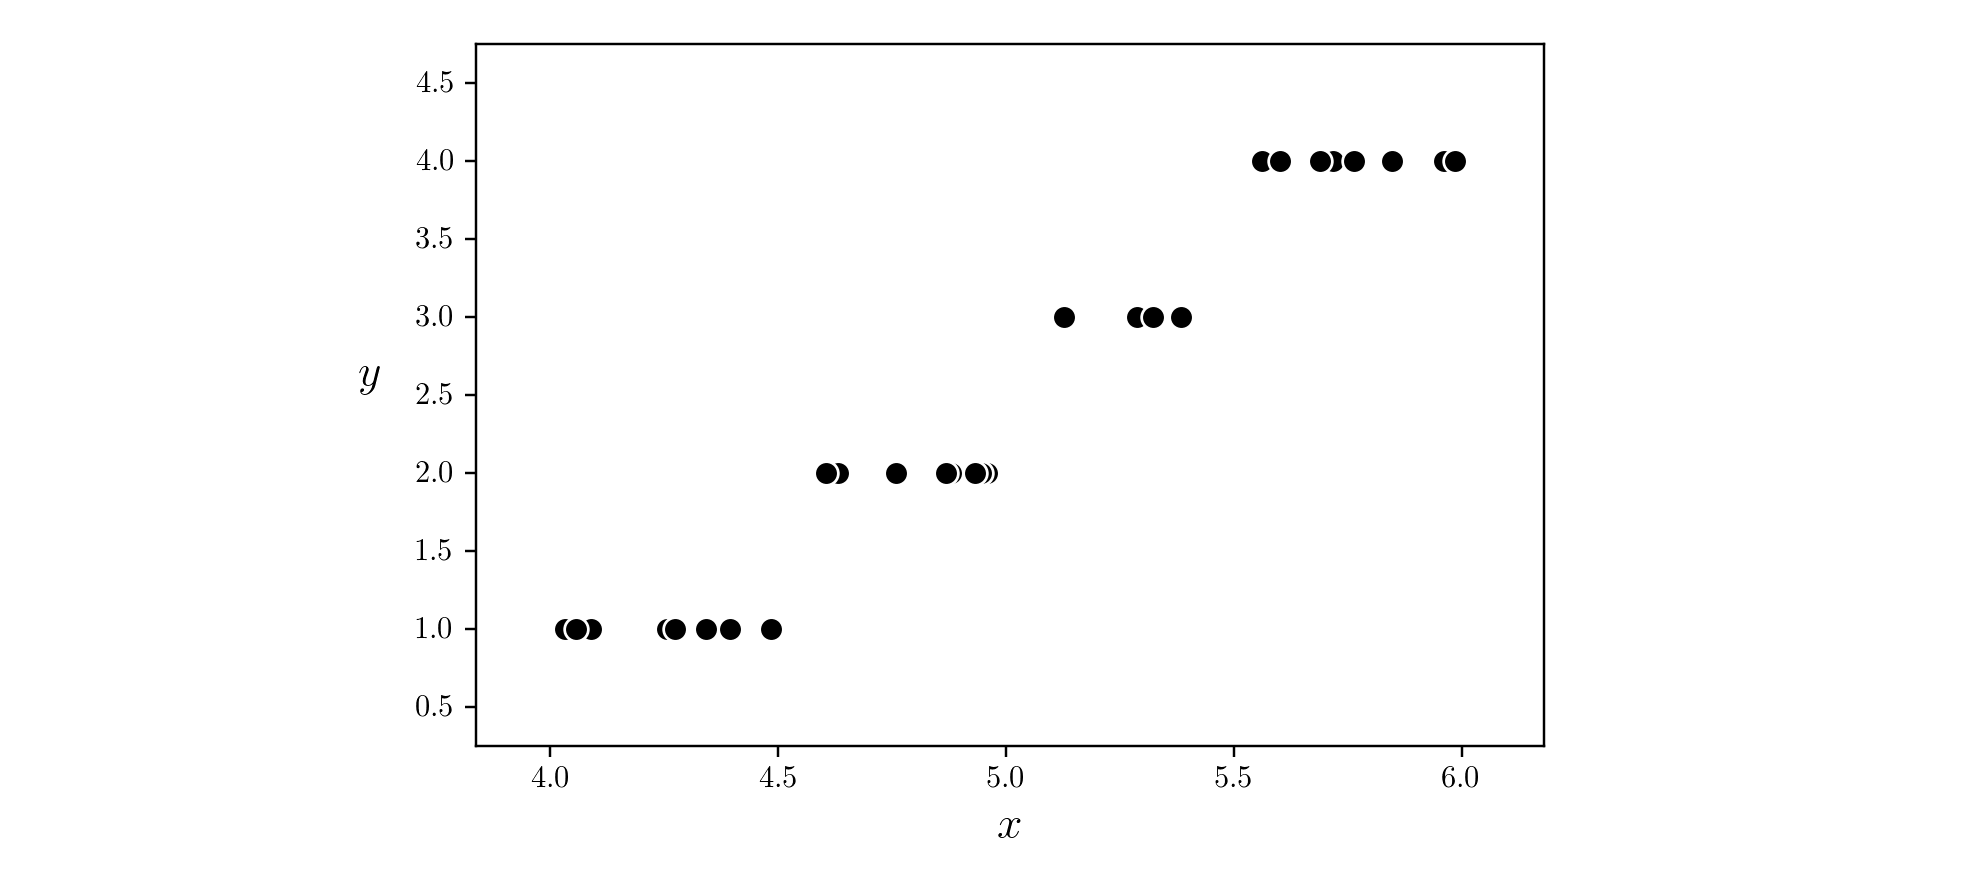

In [31]:
# load in a toy dataset to illustrate the benefits of standard normalization 
data = np.loadtxt(datapath + 'singleinput_multiclass_dataset.csv',delimiter = ',')

# get input/output pairs
x = data[:,:-1:].T 
y = data[:,-1:] 

# multiclass single-input plotter
demo = classif_plotter.Visualizer(data)
demo.plot_data()

Now we run $100$ steps of gradient descent with a fixed steplength of $10^{-3}$, the largest steplength of the form $10^{-\gamma}$ with $\gamma$ an integer we found to produce convergence.  This will not result in significant learning, since we saw in Example 2 of the previous Section that with this dataset we required close to $10,000$ iterations to produce adequate learning.  

In [55]:
# load in cost function
perceptron_1 = cost_lib.Setup(x,y,'multiclass_perceptron').cost_func
counting_cost_1 = cost_lib.Setup(x,y,'multiclass_counter').cost_func

In [65]:
# load in an optimizer
g = perceptron_1; w = np.array([[1.0,1.0,1.0,1.0],[4.0,4.0,4.0,4.0]]); max_its = 100; alpha_choice = 10**(-3);
weight_history_1,cost_history_1 = optimizers.gradient_descent(g,alpha_choice,max_its,w)
count_history_1 = [counting_cost_1(v) for v in weight_history_1]  # compute misclassification history

Plotting the learned fusion rule model employing the best set of weights from this run we can indeed see that our model performs quite poorly.

<IPython.core.display.Javascript object>


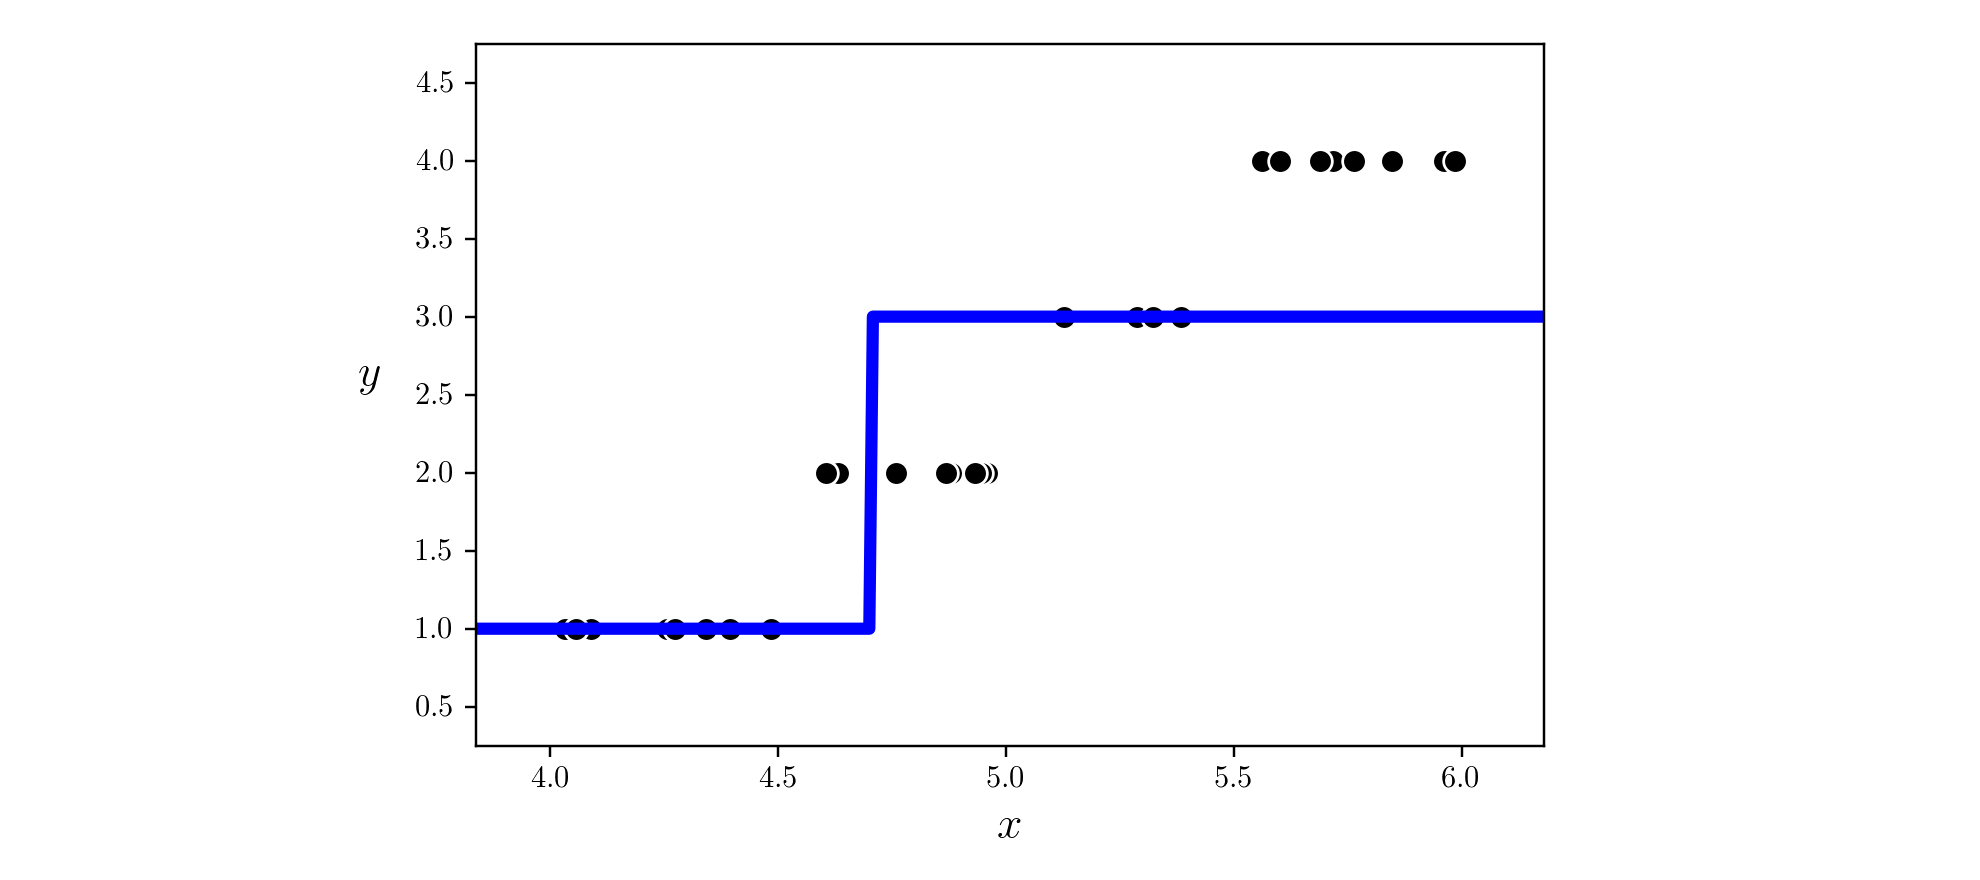

In [67]:
# the original data and the best learned logistic sigmoid and counting cost
# line learned from our gradient descent run above
ind = np.argmin(count_history_1)
best_weights = weight_history_1[ind]
demo.plot_fit(best_weights)

Now we normalize the input using standard normalization - as described in Sections 8.4, 9.4, and the subsection above.  We import `Python` functionality to perform this from a backend file called `normalizers`.

In [59]:
# create normalizer/inverse normalizer
normalizer,inverse_normalizer = normalizers.standard_normalizer(x)

# normalize input
x_normalized = normalizer(x)

# make new costs for normalized data
perceptron_2 = cost_lib.Setup(x_normalized,y,'multiclass_perceptron').cost_func
counting_cost_2 = cost_lib.Setup(x_normalized,y,'multiclass_counter').cost_func

With the input normalized we now make a run of gradient descent - much shorter and with a much larger steplength than used previously (as is typically possible when normalizing the input to a cost function).  This results in considerably better performance after just a few steps, as we plot the result of the best found weights below as well.

In [63]:
# load in an optimizer
g = perceptron_2; max_its = 30; alpha_choice = 1;
weight_history_2,cost_history_2 = optimizers.gradient_descent(g,alpha_choice,max_its,w)
count_history_2 = [counting_cost_2(v) for v in weight_history_2]  # compute misclassification history

<IPython.core.display.Javascript object>


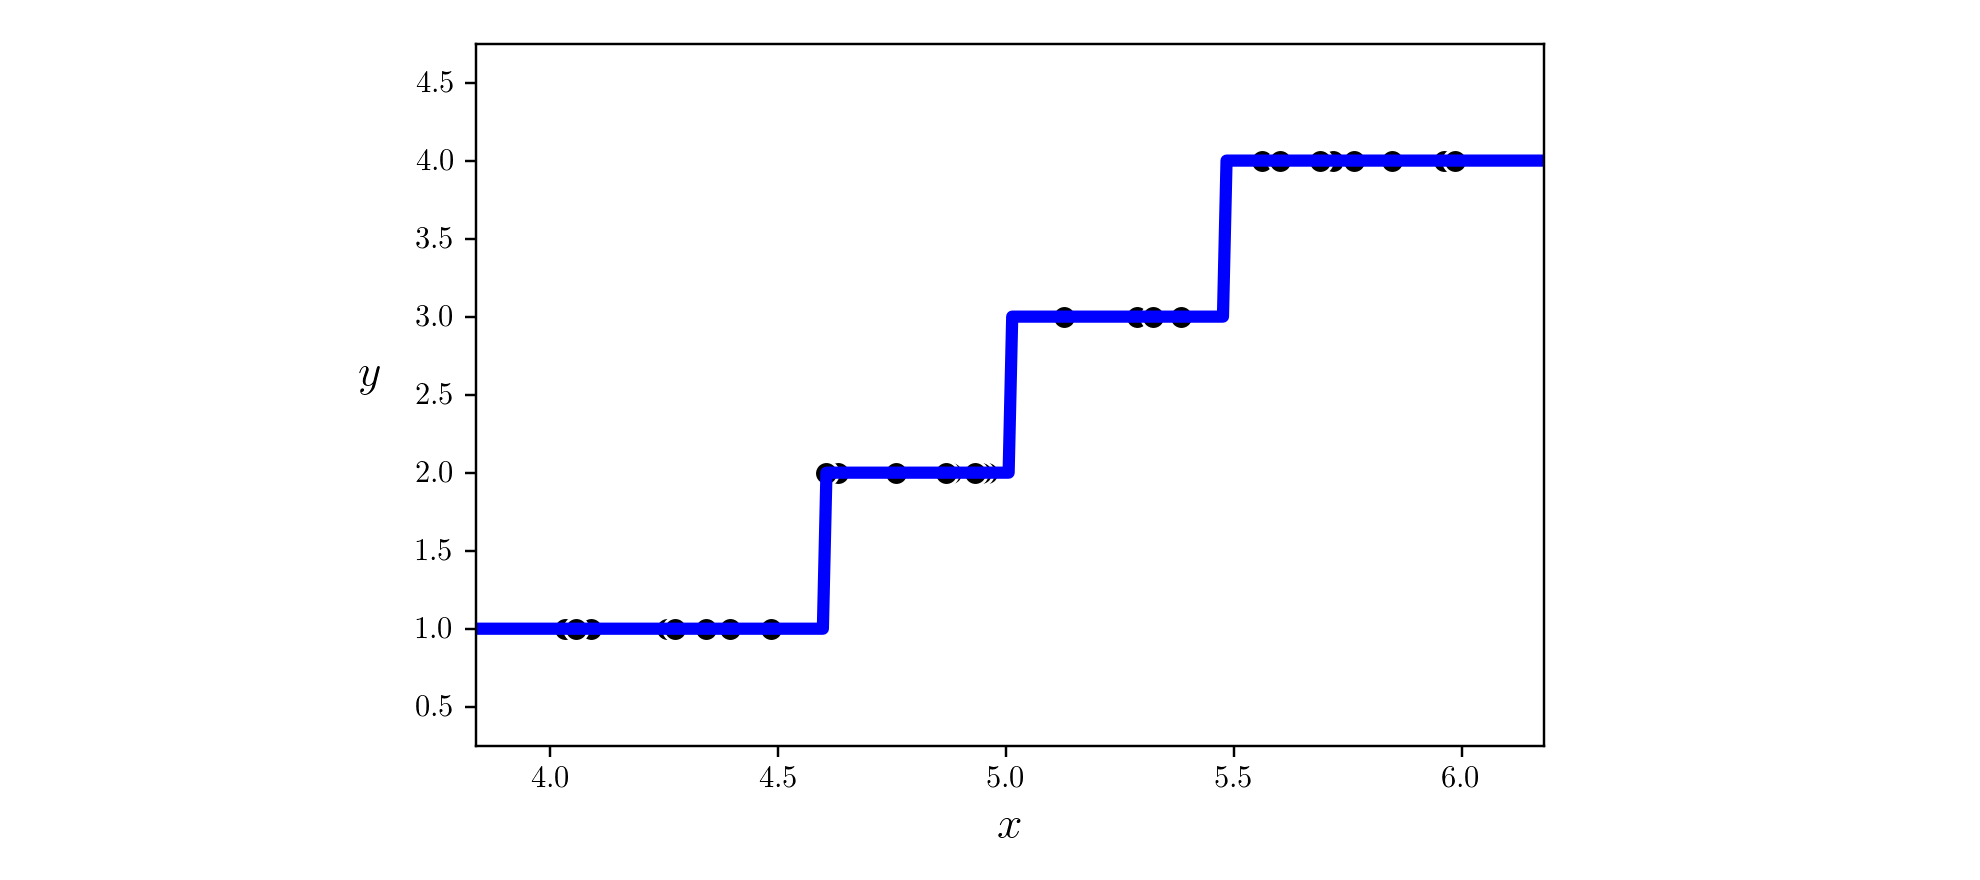

In [69]:
# the original data and the best learned logistic sigmoid and counting cost
# line learned from our gradient descent run above
ind = np.argmin(count_history_2)
best_weights = weight_history_2[ind]
demo.plot_fit(best_weights,transformer = normalizer)

If we compare the cost and misclassification count per iteration of both gradient descent runs above we can see the startling difference between gradient the two gradient descent runs.  In particular, in the time it takes for the run on standard normalized input to converge to a perfect solution the unnormalized run fails to make any real progress at all.

<IPython.core.display.Javascript object>


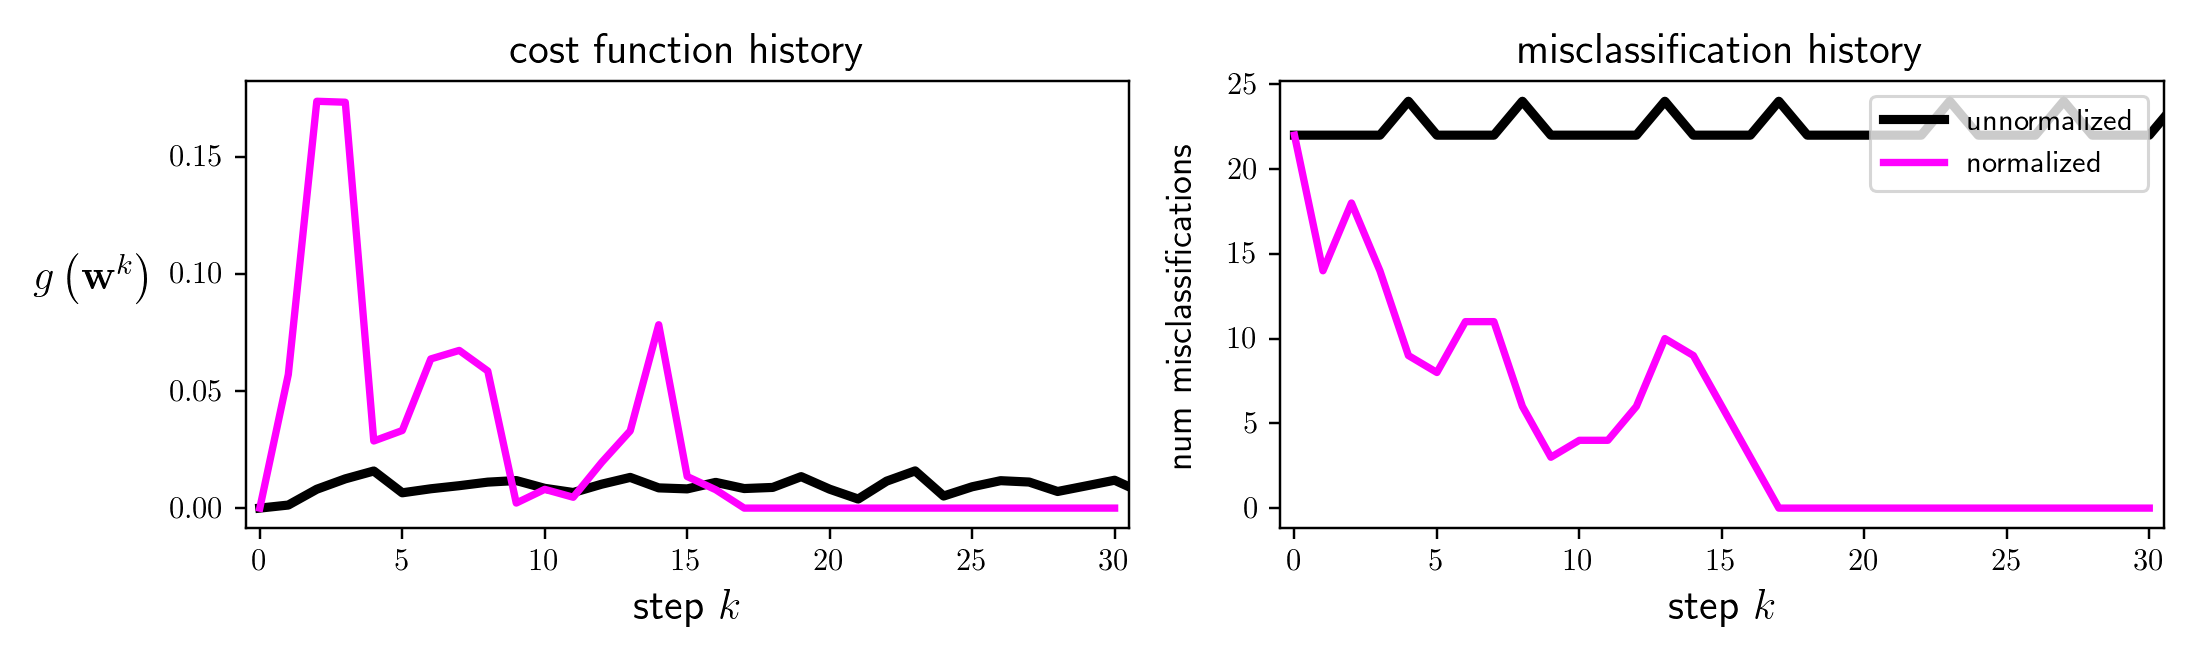

In [71]:
# plot the cost function history for a given run
classification_plotter.plot_cost_histories([weight_history_1,weight_history_2],[cost_history_1,cost_history_2],[count_history_1,count_history_2],start = 0,labels = ['unnormalized','normalized'])